# Project Title: Urban Sound Classification

### Problem Statement:
Classify the sounds of an Urban City into 10 classes: air_conditioner,car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, and street_music.

### Problem Importance:
Sounds in big urban cities can easily go over the healthy noise levels for human hearing system. For instance, it has been estimated that 9 out of 10 adults in New York City (NYC) are exposed to excessive noise levels, i.e., beyond the limit of what the EPA considers to be harmful. When applied to U.S. cities of more than 4 million inhabitants, such estimates extend to over 72 million urban residents. So, it is important to identify noise sources to mitigate it.

### Dataset: UrbanSound8k Dataset
It contains 27 hours of audio with 18.5 hours of annotated
sound event occurrences across 10 sound classes. This dataset contains 8732 labeled sound
excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, children_playing,
dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, and street_music. The
classes are drawn from the urban sound taxonomy.

### Previous work on the problem:
Sound analysis and classification was previously conducted by the NYU’s Music and Audio Research Lab and funded by NYU’s Centre for Urban Science and Progress seed grant. The previous research used Weka’s classic machine learning algorithms with default parameters. The algorithms used were SVM, KNN, Decision Tree, Random Forest, and Baseline Majority vote classifier (ZeroR). My approach would be to introduce Deep Learning into the research and use ensemble models.

In [69]:
# Importing basic libraries
import os
import librosa
import librosa.display
import glob
import skimage
import pickle
from tqdm.auto import trange, tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [70]:
basePath = "/kaggle/input/urbansound8k"
os.listdir(basePath)

['fold7',
 'fold1',
 'fold3',
 'fold5',
 'fold10',
 'UrbanSound8K.csv',
 'fold9',
 'fold8',
 'fold4',
 'fold2',
 'fold6']

In [71]:
meta_data_file_path = basePath + "/UrbanSound8K.csv"
df = pd.read_csv(meta_data_file_path)
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [72]:
# Demonstartion for loading a single audio file and computing its melspectogram with librosa library

dat1, sampling_rate1 = librosa.load(basePath + '/fold5/100032-3-0-0.wav')
arr = librosa.feature.melspectrogram(y=dat1, sr=sampling_rate1)
arr.shape

(128, 14)

### Benefits and Reasons for converting audio from amplitude scale to decibels scale:
* The decibel scale is a logarithmic scale used to measure sound intensity. It's more useful than a linear scale because the human ear perceives sound intensity logarithmically.

* Audio signals often have a wide dynamic range. Converting to the decibel scale compresses this range, making it easier to visualize and process. It helps in highlighting subtle variations in the signal that might be overlooked in a linear scale.

* In the decibel scale, noise and silence can be more easily differentiated from the actual signal.

### What does Fourier Transform do to audio data?
It is a mathematical operation that transforms the signal from the time domain into the frequency domain. This transformation reveals the frequency content of the audio signal.

* The Fourier Transform decomposes an audio signal into its constituent frequencies. This allows for the analysis of which frequencies are present in the signal and their respective amplitudes. This is crucial for understanding the harmonic content and characteristics of the audio.

*  By transforming an audio signal to the frequency domain, it becomes easier to identify and isolate noise or unwanted frequency components. This allows for targeted filtering and noise reduction processes.

* In the field of digital audio, the Fourier Transform plays a key role in compression algorithms (like MP3, AAC). These algorithms work by analyzing the frequency components of the signal and removing those that are less perceptible to human hearing, thus reducing file size without significantly impacting perceived audio quality.

### Benefits and Reasons to use Short-Time Fourier Transform (STFT) on audio signals:
*  STFT is used to convert a time-domain signal into a time-frequency domain representation. It provides a way to analyze both the frequency and temporal content of the signal.
* Audio signals are typically non-stationary, meaning their frequency content changes over time. STFT divides the signal into short frames and performs a Fourier Transform on each frame, allowing for the analysis of how the frequency content of the signal varies over time.

### Benefits and reasons to use Melspectogram:
A mel spectrogram is a visual representation of the spectrum of frequencies in a sound signal as they vary with time.

* The mel scale is based on human hearing perception, meaning it more accurately represents how humans perceive sound, especially in the context of speech and music processing.

* It helps in identifying and reducing noise in audio signals, as different types of sounds can be visually identified and isolated.

*  Mel spectrograms provide a way to analyze both time and frequency characteristics of a sound simultaneously, giving a whole view of the   audio's characteristics.

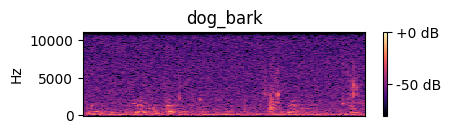

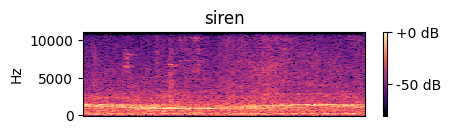

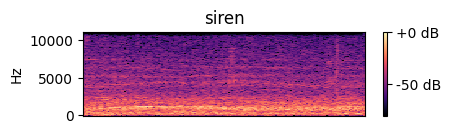

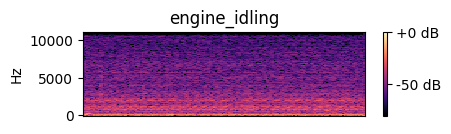

In [73]:
'''Using random samples to observe difference in waveforms.'''

arr = np.array(df["slice_file_name"])
fold = np.array(df["fold"])
cla = np.array(df["class"])

for i in range(113, 127, 4):
    path = '../input/urbansound8k/fold' + str(fold[i]) + '/' + arr[i]
    data, sampling_rate = librosa.load(path)
    plt.figure(figsize=(10, 5))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    plt.subplot(4, 2, 1)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(cla[i])


##### We can see the spectogram of the audio file. We can see specifically that the engine_idling spectogram is constant. It is to be expected as any stationary vehicle with engine turned on produces a near similar noise.

In [74]:
feature = []
label = []

def parser(df):
    '''

    Function to load files and extract features using melspectogram

    '''

    for i in trange(df.shape[0]):
        file_name = basePath + '/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
        X, sample_rate = librosa.load(file_name)
        mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate),axis=1)
        feature.append(mels)
        label.append(df["classID"][i])
    return [feature, label]

##### Extracting the features is a CPU-bound intensive process which takes time. So, the extracted features were "pickled" away in order to use them in future without computing them again.

In [75]:
# mel_features = parser(df)
# import pickle
# with open("/kaggle/working/kaggle_pickled_temp_file.pickle", 'wb') as handle:
#     pickle.dump(mel_features, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [76]:
# with open("/kaggle/working/kaggle_pickled_temp_file.pickle", "rb") as handle:
#     mel_features = pickle.load(handle)

In [77]:
# Loading the stored away features
with open("/kaggle/input/audio-mel-features-data/kaggle_pickled_temp_file.pickle", "rb") as handle:
    mel_features = pickle.load(handle)

In [78]:
np.array(mel_features[1]).shape

(8732,)

In [79]:
print(len(mel_features[0][0]))

128


In [80]:
X_root = np.array(mel_features[0])
y_root = np.array(mel_features[1])

In [81]:
X = X_root.copy()
y = y_root.copy()

print(X.shape)
print(y.shape)

(8732, 128)
(8732,)


In [82]:
# Initializing variables
random_state = 76
test_size = 0.25
is_shuffled = True
is_stratified = y

## Logistic regression
##### Logistic Regression uses a logistic function to model a binary dependent variable. This function is also known as the sigmoid function. The parameters (coefficients) of the logistic regression model are typically estimated using maximum likelihood estimation. For multi-class classification, One vs Rest and Multinomial Logistic Regression is used.


In [83]:
standard_scaling = True
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=is_shuffled, stratify=is_stratified)
if standard_scaling == True:
    std_scaler = StandardScaler()
    X_train = std_scaler.fit_transform(X_train)
    X_test = std_scaler.transform(X_test)

In [84]:
# Training Logisitic Regression model with l2 penalty
from sklearn.linear_model import LogisticRegression
log_reg_clf = LogisticRegression(penalty="l2", max_iter=10000, random_state=random_state)
log_reg_clf.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=76)

In [85]:
print(f"Number of iterations to converge: {log_reg_clf.n_iter_[0]}")

Number of iterations to converge: 340


In [86]:
log_reg_clf.score(X_test, y_test)

0.4819056344480073

In [87]:
y_pred = log_reg_clf.predict(X_test)

In [88]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.37      0.40       250
           1       0.79      0.54      0.64       107
           2       0.26      0.80      0.39       250
           3       0.49      0.41      0.44       250
           4       0.75      0.51      0.61       250
           5       0.61      0.39      0.47       250
           6       0.85      0.49      0.62        94
           7       0.79      0.60      0.68       250
           8       0.69      0.44      0.53       232
           9       0.40      0.32      0.35       250

    accuracy                           0.48      2183
   macro avg       0.61      0.49      0.52      2183
weighted avg       0.58      0.48      0.50      2183



#### This result was expected as logistic Regression does not perform well with complex, non-linear data.

## Support Vector Classifier
##### Support Vector Classifier (SVC) tries to find the best separating hyperplane (a line in 2D space, a plane in 3D space, etc.) that divides the data points into different classes. SVC looks for the hyperplane that maximizes the margin between the classes. The data points that are closest to the hyperplane (and which influence the position and orientation of the hyperplane) are known as support vectors. In cases where the data is not linearly separable, SVC uses a method called the kernel trick. This technique  maps data to a higher-dimensional space where a linear separation is possible. Common kernels include linear, polynomial, radial basis function (RBF), and sigmoid.

In [89]:
standard_scaling = False
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=is_shuffled, stratify=is_stratified)
if standard_scaling == True:
    std_scaler = StandardScaler()
    X_train = std_scaler.fit_transform(X_train)
    X_test = std_scaler.transform(X_test)

In [90]:
from sklearn.svm import SVC
svc_clf = SVC(C=1e3, kernel="rbf", gamma="auto", random_state=random_state)
svc_clf.fit(X_train, y_train)

SVC(C=1000.0, gamma='auto', random_state=76)

In [91]:
print(f"Number of iterations to converge: {svc_clf.n_iter_[0]}")

Number of iterations to converge: 6206


In [92]:
svc_clf.score(X_test, y_test)

0.56481905634448

In [93]:
y_pred = svc_clf.predict(X_test)

In [94]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77       250
           1       0.47      0.21      0.29       107
           2       0.48      0.51      0.49       250
           3       0.53      0.35      0.42       250
           4       0.82      0.57      0.67       250
           5       0.84      0.72      0.78       250
           6       0.55      0.17      0.26        94
           7       0.86      0.68      0.76       250
           8       0.61      0.56      0.58       232
           9       0.26      0.63      0.37       250

    accuracy                           0.56      2183
   macro avg       0.62      0.52      0.54      2183
weighted avg       0.63      0.56      0.58      2183



#### Support Vector Machine performed decently with this data.

## Decision Tree
##### A Decision Tree is built top-down from a root node and involves partitioning the data into subsets that contain instances with homogenous values. Common Impurity measures are Gini Index and Entropy. To avoid overfitting, trees are often pruned, which involves cutting back the tree to a size that is more manageable and effective for prediction.

In [95]:
standard_scaling = False
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
if standard_scaling == True:
    std_scaler = StandardScaler()
    X_train = std_scaler.fit_transform(X_train)
    X_test = std_scaler.transform(X_test)

In [96]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(criterion="gini", splitter="best", max_depth=None, ccp_alpha=0.0001)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0001)

In [97]:
dt_clf.score(X_test, y_test)

0.6706367384333486

In [98]:
y_pred = dt_clf.predict(X_test)

In [99]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.81      0.80       246
           1       0.53      0.44      0.48        99
           2       0.49      0.51      0.50       272
           3       0.63      0.60      0.62       263
           4       0.67      0.70      0.68       221
           5       0.83      0.83      0.83       275
           6       0.60      0.57      0.58        86
           7       0.78      0.80      0.79       258
           8       0.73      0.73      0.73       233
           9       0.51      0.49      0.50       230

    accuracy                           0.67      2183
   macro avg       0.65      0.65      0.65      2183
weighted avg       0.67      0.67      0.67      2183



#### Decision Tree performed fairly-well on the data.

#### This result strengthens our hypothesis that tree-based models should work well.

## Random Forest Classifier
##### Random Forest belongs to the family of ensemble learning methods, where multiple models are combined to solve a problem. It uses an ensemble of decision trees to make more accurate and stable predictions. Random Forest combines multiple decision trees to form a more robust model. Each tree in the forest is trained on a random subset of the data and features, making the ensemble less susceptible to overfitting than a single decision tree. For classification, the final prediction of the Random Forest is the class that receives the majority vote from individual trees.

In [100]:
standard_scaling = True
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=is_shuffled, stratify=is_stratified)
if standard_scaling == True:
    std_scaler = StandardScaler()
    X_train = std_scaler.fit_transform(X_train)
    X_test = std_scaler.transform(X_test)

In [101]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(criterion="gini", max_depth=None, ccp_alpha=0.0001, random_state=random_state)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(ccp_alpha=0.0001, random_state=76)

In [102]:
rf_clf.score(X_test, y_test)

0.8621163536417774

In [103]:
y_pred = rf_clf.predict(X_test)

In [104]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       250
           1       1.00      0.77      0.87       107
           2       0.72      0.81      0.76       250
           3       0.87      0.79      0.83       250
           4       0.88      0.90      0.89       250
           5       0.96      0.95      0.95       250
           6       0.93      0.74      0.83        94
           7       0.86      0.92      0.89       250
           8       0.92      0.94      0.93       232
           9       0.74      0.72      0.73       250

    accuracy                           0.86      2183
   macro avg       0.88      0.85      0.86      2183
weighted avg       0.87      0.86      0.86      2183



#### As we expected, Random Forest Classifier performed good

## XGBoost : eXtreme Gradient Boosting
##### XGBoost is an advanced implementation of gradient boosting algorithm. It constructs new models that predict the residuals or errors of prior models and then adds them together to make the final prediction. It builds the model in a stage-wise fashion, like other boosting methods, but it generalizes them by allowing optimization of arbitrary differentiable loss functions. XGBoost performs depth-first growth of trees with pruning afterward, leading to a more balanced and generalized tree. For each tree, it computes the gradient and hessian (second-order derivative) of the loss function with respect to the prediction, which allows for more efficient and effective learning.

In [105]:
!pip install xgboost

In [106]:
standard_scaling = False
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=is_shuffled, stratify=is_stratified)
if standard_scaling == True:
    std_scaler = StandardScaler()
    X_train = std_scaler.fit_transform(X_train)
    X_test = std_scaler.transform(X_test)

In [107]:
import xgboost
xgb_clf = xgboost.XGBClassifier(max_depth=None, objective="multi:softprob",random_state=random_state)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [108]:
xgb_clf.score(X_test, y_test)

0.8790655061841502

In [109]:
y_pred = xgb_clf.predict(X_test)

In [110]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       250
           1       0.98      0.76      0.85       107
           2       0.76      0.84      0.80       250
           3       0.89      0.81      0.85       250
           4       0.91      0.89      0.90       250
           5       0.93      0.96      0.94       250
           6       0.88      0.74      0.80        94
           7       0.91      0.94      0.93       250
           8       0.93      0.96      0.94       232
           9       0.78      0.79      0.78       250

    accuracy                           0.88      2183
   macro avg       0.89      0.86      0.87      2183
weighted avg       0.88      0.88      0.88      2183



#### As we expected, XGBoost Classifier performed better on the data as it is a tree-based model.

## Artificial Neural Network (ANN) :
##### ANNs are composed of nodes / neurons organized in layers: an input layer, one or more hidden layers, and an output layer. Each node in one layer is connected to nodes in the next layer through weights. Every neuron applies a transformation to its inputs — typically a weighted sum followed by a non-linear activation function. The parameters of the network that are adjusted during training. Weights determine the strength of the influence one neuron has on another, while biases allow the network to shift the activation function. It uses backpropagation algorithm  for training the network, involving a backward pass to adjust the weights, using methods like gradient descent to minimize the error between the actual and predicted outputs.

In [111]:
standard_scaling = False
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=is_shuffled, stratify=is_stratified)
if standard_scaling == True:
    std_scaler = StandardScaler()
    X_train = std_scaler.fit_transform(X_train)
    X_test = std_scaler.transform(X_test)

In [112]:
import tensorflow as tf
import keras
from keras import layers

In [113]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6549, 128)
(6549,)
(2183, 128)
(2183,)


In [114]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPU


In [115]:
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
    activation_fn = "relu"
    model = keras.Sequential(
        [
            layers.Dense(units=128, activation=activation_fn, input_shape=(128,)),
            layers.Dense(units=256, activation=activation_fn),
            layers.Dense(units=512, activation=activation_fn),
            layers.Dropout(0.2),
            layers.Dense(units=337, activation=activation_fn),
            layers.Dense(units=221, activation=activation_fn),
            layers.BatchNormalization(),
            layers.Dense(units=164, activation=activation_fn),
            layers.Dense(units=88, activation=activation_fn),
            layers.Dense(units=41, activation=activation_fn),
            layers.BatchNormalization(),
            layers.Dense(units=23, activation=activation_fn),
            layers.Dense(units=10, activation="Softmax")
        ]
    )


    es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=10e-7,
    patience=15,
    verbose=1,
    mode='min',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=100
)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics = ['accuracy']
                 )

#     We are not going to use the Early Stopping callback in order to visualize the plateau of the training curves.

    history = model.fit(X_train, y_train, batch_size=512, epochs=500, validation_data=(X_test, y_test))



Epoch 1/500
13/13 [==============================] - 5s 38ms/step - loss: 2.2441 - accuracy: 0.1655 - val_loss: 5.9044 - val_accuracy: 0.0898
Epoch 2/500
13/13 [==============================] - 0s 15ms/step - loss: 2.1723 - accuracy: 0.1954 - val_loss: 3.2052 - val_accuracy: 0.1686
Epoch 3/500
13/13 [==============================] - 0s 15ms/step - loss: 2.1573 - accuracy: 0.1980 - val_loss: 2.8389 - val_accuracy: 0.1686
Epoch 4/500
13/13 [==============================] - 0s 14ms/step - loss: 2.1345 - accuracy: 0.2095 - val_loss: 2.4102 - val_accuracy: 0.1672
Epoch 5/500
13/13 [==============================] - 0s 15ms/step - loss: 2.1208 - accuracy: 0.2226 - val_loss: 2.2768 - val_accuracy: 0.1704
Epoch 6/500
13/13 [==============================] - 0s 14ms/step - loss: 2.1102 - accuracy: 0.2261 - val_loss: 2.1931 - val_accuracy: 0.1837
Epoch 7/500
13/13 [==============================] - 0s 14ms/step - loss: 2.0822 - accuracy: 0.2364 - val_loss: 2.1390 - val_accuracy: 0.2034
Epoch 

In [116]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dense_13 (Dense)            (None, 256)               33024     
                                                                 
 dense_14 (Dense)            (None, 512)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 337)               172881    
                                                                 
 dense_16 (Dense)            (None, 221)               74698     
                                                                 
 batch_normalization_2 (Bat  (None, 221)              

In [117]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

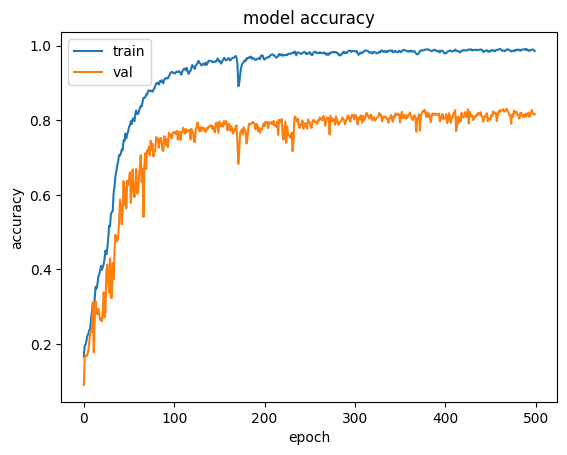

In [118]:
# Accuracy history as training progresses
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

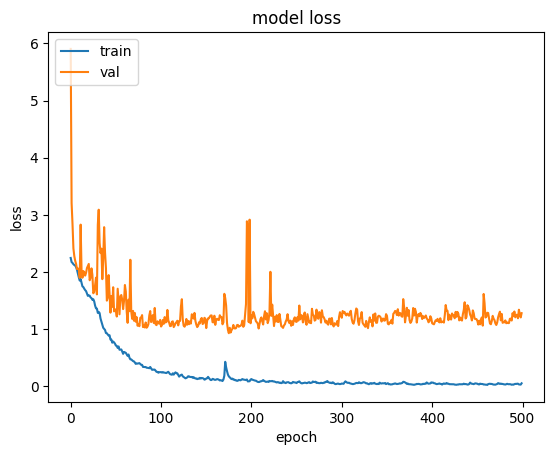

In [119]:
# Loss history as training progresses
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [120]:
y_pred = model.predict(X_test)

69/69 [==============================] - 0s 2ms/step


In [121]:
y_pred_new = []

for i in y_pred:
    y_pred_new.append(i.argmax())

In [122]:
y_pred_new = np.array(y_pred_new)
y_pred_new.shape

(2183,)

In [123]:
print(classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       250
           1       0.95      0.66      0.78       107
           2       0.71      0.55      0.62       250
           3       0.74      0.71      0.73       250
           4       0.89      0.85      0.87       250
           5       0.93      0.94      0.93       250
           6       0.86      0.74      0.80        94
           7       0.84      0.95      0.89       250
           8       0.85      0.89      0.87       232
           9       0.64      0.78      0.71       250

    accuracy                           0.82      2183
   macro avg       0.83      0.80      0.81      2183
weighted avg       0.82      0.82      0.81      2183



## Convolutional Neural Network (CNN)
##### Convolutional Neural Networks are a specialized kind of neural network used primarily for processing structured array data such as images. Convolutional layers apply a convolution operation to the input, passing the result to the next layer. They do the filtering operation from the image processing domain. They are used to detect features like edges, textures, and complex patterns in the input image. Pooling layers reduce the dimensions of the data by combining the outputs of neuron clusters at one layer into a single neuron in the next layer. Common pooling methods include max pooling and average pooling. At the end of the network, one or more fully connected layers are used where every input is connected to every output. They are used to flatten the output of convolutional and pooling layers into a single vector, which is used for classifying the image. The nature of CNNs is extracting hierarchical, local features from any form of structured data, whether it's visual or auditory. So, it also works for our audio data.

In [124]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical

In [125]:
standard_scaling = False

X_train_CNN, X_test_CNN, y_train_CNN, y_test_CNN = train_test_split(X, y, test_size=0.15, random_state=random_state, shuffle=is_shuffled, stratify=is_stratified)
if standard_scaling == True:
    std_scaler = StandardScaler()
    X_train_CNN = std_scaler.fit_transform(X_train_CNN)
    X_test_CNN = std_scaler.transform(X_test_CNN)

In [126]:
X_train_CNN = X_train_CNN.reshape(X_train_CNN.shape[0], 16, 8, 1)
X_test_CNN = X_test_CNN.reshape(X_test_CNN.shape[0], 16, 8, 1)
input_dim = (16, 8, 1)

In [127]:
X_train_CNN.shape

(7422, 16, 8, 1)

In [128]:
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
    model_CNN = keras.Sequential(
        [
            layers.Conv2D(128, (3, 3), padding = "same", activation = "tanh", input_shape = input_dim),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Conv2D(64, (3, 3), padding = "same", activation = "tanh"),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Dropout(0.21),
            layers.Conv2D(32, (3, 3), padding = "same", activation = "tanh"),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(1024, activation = "tanh"),
            layers.Dense(10, activation = "softmax")
        ]
    )


    es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=5
)

#     Adam is efficient with large datasets, high dimensional spaces and is robust to noisy gradients
#     Sparse Categorical Cross-entropy loss is memory efficient and suitable for our label type.

    model_CNN.compile(optimizer="adam",
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics = ['accuracy']
                 )

#     We are not going to use the Early Stopping callback in order to visualize the plateau of the training curves.

    history_CNN = model_CNN.fit(X_train_CNN, y_train_CNN, batch_size=256, epochs=500, validation_data=(X_test_CNN, y_test_CNN), validation_batch_size=256)

Epoch 1/500


2024-05-26 01:19:47.801311: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


29/29 [==============================] - 2s 18ms/step - loss: 1.9169 - accuracy: 0.3274 - val_loss: 1.6012 - val_accuracy: 0.4191
Epoch 2/500
29/29 [==============================] - 0s 9ms/step - loss: 1.4945 - accuracy: 0.4690 - val_loss: 1.4167 - val_accuracy: 0.5015
Epoch 3/500
29/29 [==============================] - 0s 9ms/step - loss: 1.3143 - accuracy: 0.5366 - val_loss: 1.2333 - val_accuracy: 0.5725
Epoch 4/500
29/29 [==============================] - 0s 9ms/step - loss: 1.1762 - accuracy: 0.5909 - val_loss: 1.1545 - val_accuracy: 0.6313
Epoch 5/500
29/29 [==============================] - 0s 9ms/step - loss: 1.0768 - accuracy: 0.6393 - val_loss: 1.0421 - val_accuracy: 0.6466
Epoch 6/500
29/29 [==============================] - 0s 9ms/step - loss: 0.9797 - accuracy: 0.6686 - val_loss: 0.9867 - val_accuracy: 0.6779
Epoch 7/500
29/29 [==============================] - 0s 9ms/step - loss: 0.9132 - accuracy: 0.6884 - val_loss: 0.9383 - val_accuracy: 0.6786
Epoch 8/500
29/29 [=====

In [129]:
model_CNN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 16, 8, 128)        1280      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 8, 4, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 4, 64)          73792     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 4, 2, 64)          0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 4, 2, 64)          0         
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 2, 32)         

In [130]:
history_CNN.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

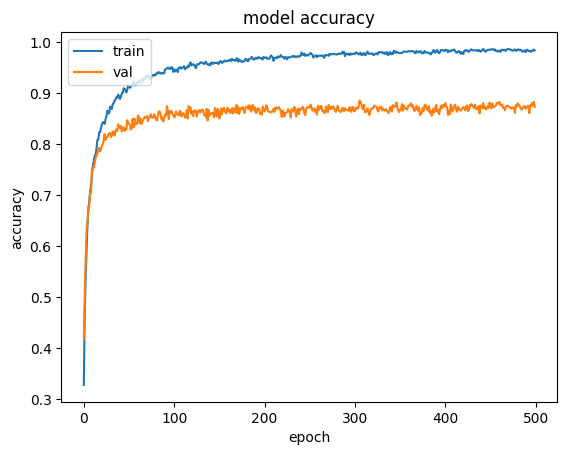

In [131]:
# Visualizing the model accuracy during training
plt.plot(history_CNN.history['accuracy'])
plt.plot(history_CNN.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

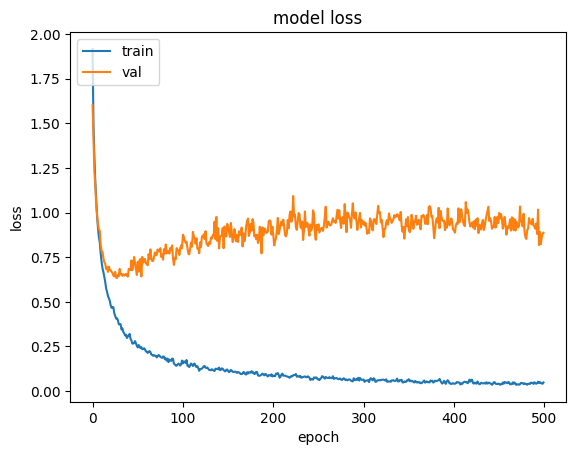

In [132]:
# Visualizing the model loss during training
plt.plot(history_CNN.history['loss'])
plt.plot(history_CNN.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [133]:
y_pred = model_CNN.predict(X_test_CNN)

41/41 [==============================] - 0s 2ms/step


In [134]:
y_pred_new = []

for i in y_pred:
    y_pred_new.append(i.argmax())

In [135]:
y_pred_new = np.array(y_pred_new)
y_pred_new.shape

(1310,)

In [136]:
print(classification_report(y_test_CNN, y_pred_new))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       150
           1       0.90      0.88      0.89        64
           2       0.72      0.74      0.73       150
           3       0.86      0.71      0.78       150
           4       0.96      0.87      0.91       150
           5       0.94      0.94      0.94       150
           6       0.83      0.88      0.85        56
           7       0.89      0.98      0.93       150
           8       0.89      0.93      0.91       140
           9       0.85      0.85      0.85       150

    accuracy                           0.87      1310
   macro avg       0.87      0.87      0.87      1310
weighted avg       0.87      0.87      0.87      1310



### Accuracies of all the models:

* Logistic Regression		:	50%
* Support Vector Machine	:	61%
* Decision Tree			:	68%
* Random Forest			:	86%
* XGBoost			:	87%
* Artificial Neural Network	:	80%
* Convolutional Neural Network	:	86%

### Findings:

* These results support that Machine Learning Models are just as good as Deep Learning models in some use cases and not all deep learning models excel at all problems. So, simpler models are better as they are more efficient and more interpretable.

* Tree based models and deep learning models yielded good accuracies.

* Rather than scaling the data, the data should be used as it is because it is already transformed specifically for this purpose.

* The architecture of a Neural Network (ANN or CNN) is more important than the number of epochs that the model has trained on after a specific limit. In our case, Early Stopping Callback would have helped with reducing unnecessary training resulting into more efficient and "green" computing. Even after training for 500 epochs, the model's accuracy was the similar to when it was trained for 250 epochs because most of the learning happened in the first 100 epochs.

### Future Improvements / Strategies I would like to experiment with:

* I would like to use Transfer Learning. I would like to extract embeddings from the State of the Art Audio Models and then create a database of embeddings and compare the embeddings with the train embeddings stored in the database. And would yield the result based on similarity / distance matrix.

* I would also like to use vector databases in order to perform the above said task.